In [1]:
import scanpy as sc
import scvi
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Global seed set to 0


In [2]:
tox_adata = sc.read_h5ad("/project2/gilad/jpopp/cellcipher/data_071023/single_cell_objects/filtered_pflog1ppfnorm.hvg.umap_embedding.h5ad")
#tox_adata_raw = sc.read_h5ad("/project2/gilad/jpopp/cellcipher/data_071023/single_cell_objects/filtered.h5ad")

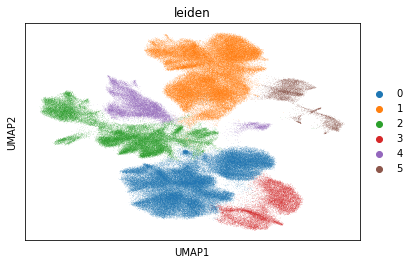

In [4]:
sc.pl.umap(tox_adata, color='leiden')

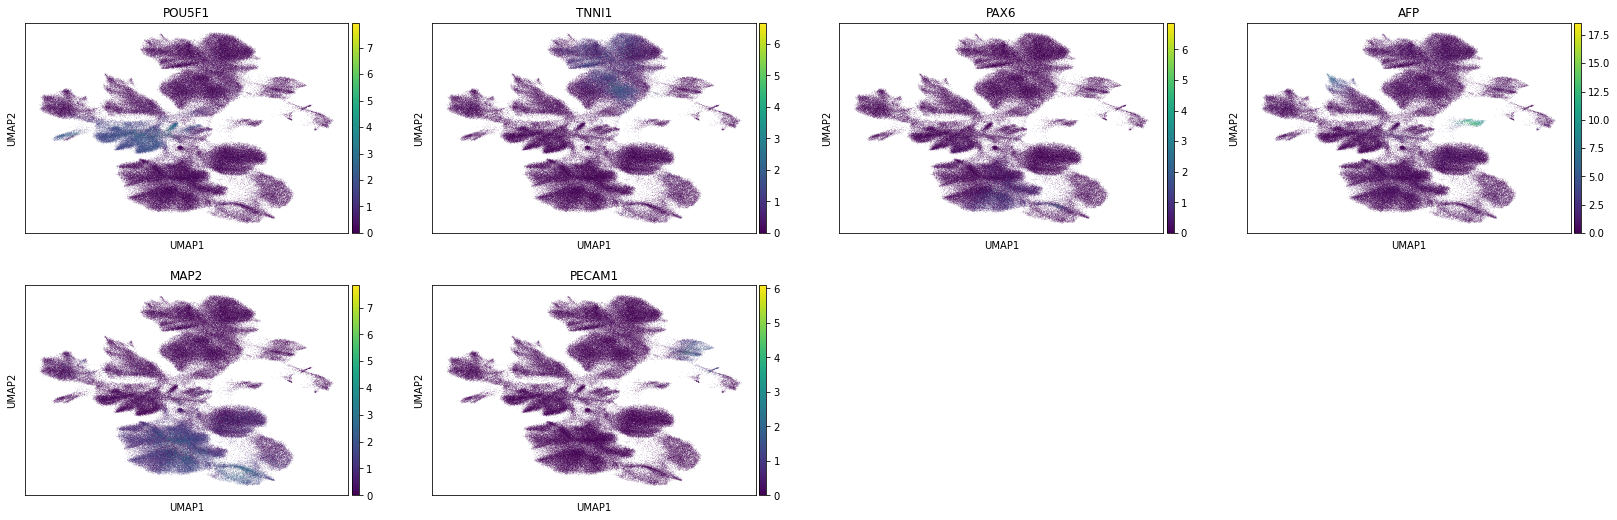

In [5]:
sc.pl.umap(tox_adata, color=['POU5F1', 'TNNI1', 'PAX6', 'AFP', 'MAP2', 'PECAM1'])

In [6]:
celltype_labels = {0: 'earlyecto', 1:'mesoderm', 2: 'pluripotent', 3: 'neuron', 4: 'endoderm', 5: 'endothelial'}

In [7]:
tox_adata.obs['celltype'] = [celltype_labels[int(c)] for c in tox_adata.obs['leiden']]

In [9]:
cell_subset = tox_adata.obs[['sample_id', 'donor_id', 'celltype']]
cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)
tox_adata.obs['pseudobulk_sample'] = cell_subset['pseudobulk_sample']

/tmp/jobs/29939328/ipykernel_164657/953043472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_subset['pseudobulk_sample'] = cell_subset['sample_id'].astype(str) + '_' + cell_subset['donor_id'].astype(str) + '_' + cell_subset['celltype'].astype(str)


In [12]:
hep_genes = ['ALB', 'AFP', 'PROX1', 'ONECUT3', 'NR5A2', 'HHEX', 'HNF4A', 'FOXA1', 'HNF1A', 
            'TTR', 'SERPINA1', 'KRT8', 'KRT18', 'PCK1', 'TDO2', 'TAT', 'CYP7A1', 'CYP3A4', 'CYP2B6']

Compare hepatoblast scores across all pseudobulk samples - are controls just lower?

In [13]:
sc.tl.score_genes(tox_adata, gene_list=hep_genes, score_name='hep_score_1')

/scratch/midway2/jpopp/.conda/envs/scvi-scanpy/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


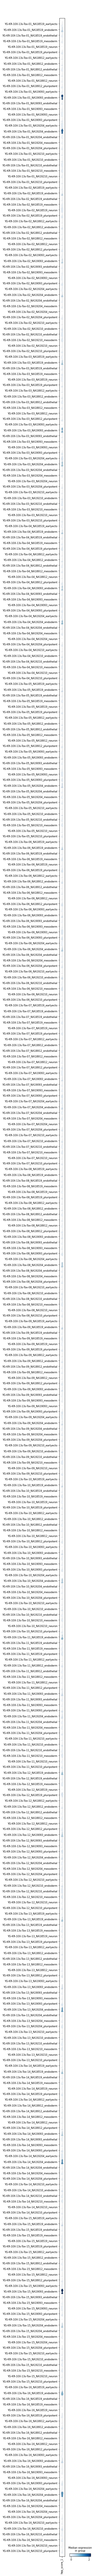

In [19]:
sc.pl.stacked_violin(tox_adata, var_names='hep_score_1', groupby='pseudobulk_sample')

In [14]:
onehot = OneHotEncoder(sparse=True).fit_transform(cell_subset[['pseudobulk_sample']])
onehot

<234913x449 sparse matrix of type '<class 'numpy.float64'>'
	with 234913 stored elements in Compressed Sparse Row format>

In [22]:
pseudobulk_sum = tox_adata_raw.X.transpose() * onehot

In [23]:
pseudobulk_sum = pd.DataFrame(pseudobulk_sum.todense(),
                              index=tox_adata_raw.var_names, 
                              columns=cell_subset['pseudobulk_sample'].astype("category").cat.categories).astype(int)

In [25]:
pseudobulk_sum.to_csv("/project2/gilad/jpopp/cellcipher/data_071023/pseudobulk_expression.tsv", sep="\t")

In [26]:
treatment_dict = tox_adata.obs[['sample_id', 'treatment']].drop_duplicates()

In [28]:
treatment_dict.to_csv("/project2/gilad/jpopp/cellcipher/data_071023/treatment_dict.tsv", sep="\t", index=False)